In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
# download the cases csv from github with pandas, for incident cases (up to 2023-03-04)

# source: https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth
# hosp
url = 'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv'
# cases
url= "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"
epidata_df = pd.read_csv(url)
epidata_df = epidata_df[epidata_df['location'] == 'US'].set_index("date")["value"]
epidata_df.index = pd.to_datetime(epidata_df.index)
epidata_df

/var/folders/y5/jj4qlxkx619gkh07d2zt6h840000gn/T/ipykernel_15777/1928283484.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  epidata_df = pd.read_csv(url)


date
2020-01-22        1
2020-01-23        0
2020-01-24        1
2020-01-25        0
2020-01-26        3
              ...  
2023-02-28    42553
2023-03-01    83376
2023-03-02    61160
2023-03-03    60103
2023-03-04     1932
Name: value, Length: 1138, dtype: int64

<AxesSubplot:xlabel='date'>

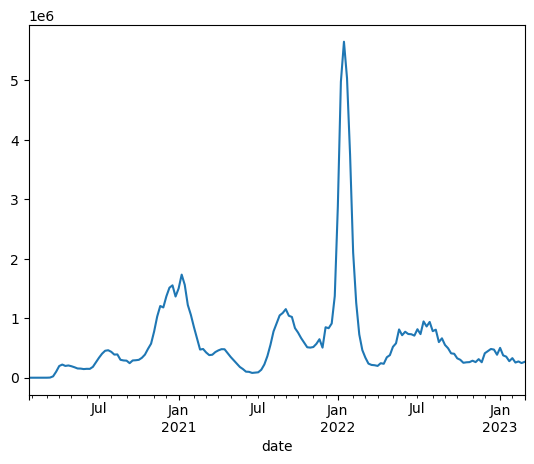

In [3]:
epidata_df = epidata_df.resample("W-SAT").sum()
epidata_df.plot()

In [19]:
import boto3, re
bucket = "idd-inference-runs"  # 'idd-inference-runs'
s3 = boto3.client("s3")
paginator = s3.get_paginator("list_objects_v2")
pages = paginator.paginate(Bucket=bucket, Prefix="", Delimiter="/")  # needs paginator cause more than 1000 files

prefixes = []
rundates = []
for page in pages:
    for cp in page["CommonPrefixes"]:
        prefix = cp["Prefix"]
        print(prefix)
        m = re.search(r"\d", prefix)
        try:
            timestamp = prefix[m.start() : m.start() + 8]
            rundate = datetime.datetime.strptime(timestamp, "%Y%m%d").date()
            if "test" not in prefix:
                rundates.append(rundate)
                prefixes.append(prefix)
        except:
            print("ERROR: ", prefix)

run_counts = pd.Series(rundates).value_counts().sort_index()
run_counts.index = pd.to_datetime(run_counts.index)
run_counts_w = run_counts.resample("W-SAT").sum()

California-20200527T203127-Lockdown_continued-med/
California-20200527T203127-Lockdown_fastOpen-med/
California-20200527T203127-Lockdown_moderateOpen-med/
California-20200527T203127-Lockdown_slowOpen-med/
California-20200528T012002-Lockdown_continued-low/
California-20200528T012002-Lockdown_fastOpen-low/
California-20200528T012002-Lockdown_moderateOpen-low/
California-20200528T012002-Lockdown_slowOpen-low/
California-20200528T012123-Lockdown_continued-high/
California-20200528T012123-Lockdown_fastOpen-high/
California-20200528T012123-Lockdown_moderateOpen-high/
California-20200528T012123-Lockdown_slowOpen-high/
California-20200606T155532-June_inference-high/
California-20200606T155548-June_inference-med/
California-20200606T155602-June_inference-low/
California-20200609T010133-June_inference-m/
California-20200609T010817-June_inference-m/
USA-20200512T150628-local_variance_LockdownWideEffect_post50_firstcase_10x-high/
USA-20200513T052713-local_variance_LockdownWideEffect_post50_firstca

<AxesSubplot:>

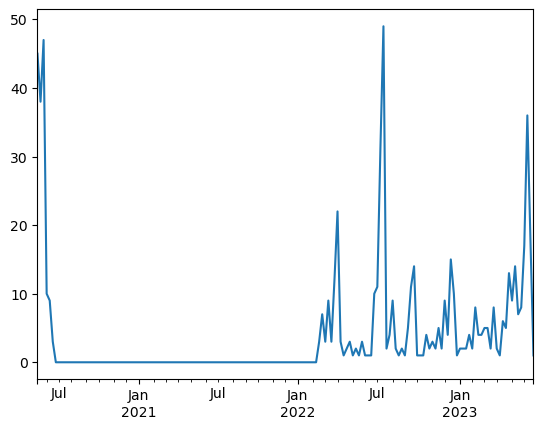

In [18]:
run_counts_w.plot()

In [5]:
run_counts_w.sum()

627

In [6]:
pref = [p[:2].lower() for p in prefixes]

In [7]:
locs = pd.Series(pref,index = rundates).sort_index()
locs[locs != "us"]

2020-05-14    mi
2020-05-14    mi
2020-05-14    mi
2020-05-14    mi
2020-05-15    we
              ..
2020-06-06    ca
2020-06-06    ca
2020-06-06    ca
2020-06-09    ca
2020-06-09    ca
Length: 87, dtype: object

In [8]:
# In case the above fails, e.g. because of missing internet connection
# use the following lists as fallback.

# highlighting
# mission change, pandemic change and technical changes.


timeline = {
    "2020-02-02": ["First US COVID-19 death", "epi"],
    "2021-12-01": ["First US Omicron case", "epi"], # https://www.cdc.gov/media/releases/2021/s1201-omicron-variant.html
    "2020-12-14": ["Mass vaccination campaign starts", "epi"], # https://en.wikipedia.org/wiki/COVID-19_vaccination_in_the_United_States
    "2021-03-01": ["Delta identified in the US", "epi"], # https://www.baptisthealth.com/connect-learn/covid19/covid19-resources/covid-19-variants/delta-variant#:~:text=The%20first%20recorded%20cases%20of,the%20U.S.%20in%20March%202021.

    "2020-02-28": ["FlepiMoP debuts", "tech"],
    "2020-03-02": ["First report to CDPH", "mission"],
    "2020-04-18": ["First runs on AWS", "tech"], # In folder idd-pipeline-results, I think it was before but rephas without s3
    "2022-01-31": ["Last state (CA) specific run", "mission"],
   
# features: inference, vaccination, variants + age-structure, county runs, national runs.
    "2020-05-05": ["Inference added", "tech"], #>> git log --follow --format=%ad --date default R/scripts/filter_MC.R | tail -1   << gives ---Mon Apr 27 13:14:13 2020 -0400 but May 5 for operational
    "2021-01-13": ["Vaccination enabled", "tech"],
    "2021-06-04": ["Any compartmental structure enabled", "tech"],
    "2022-02-01": ["gempyor package developed", "tech"],
    "2022-06-13": ["Adapted to Influenza", "tech"],   # github creation of Flu_USA
    "2022-09-23": ["Flu Scenario Modeling Hub R1", "mission"],   # github last R1 commit
    "2023-01-23": ["First runs on HPC", "tech"],   # #csp_production first message
    "2023-02-20": ["Post-processing automated", "tech"],   # #csp_production first message

# forecast Hubs, scenario hubs
 "2020-04-28": ["First COVID-19 Forecast Hub runs", "mission"], # https://iddynamicsjhu.slack.com/archives/GU0SBC2AC/p1588097182025700
 "2021-01-08": ["COVID-19 Scenario Modeling Hub R1", "mission"], #https://github.com/midas-network/covid19-scenario-modeling-hub/tree/master/data-processed/JHU_IDD-CovidSP, Scenario defined as of 2020-12-22

}

timeline = pd.DataFrame.from_dict(timeline, orient='index', columns=['event', 'type'])
timeline.index.name = 'date'
timeline.sort_index(inplace=True)

names = timeline.event.to_list()
dates = timeline.index.to_list()
types = timeline.type.to_list()


# Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates]
timeline

event     type
date                                                    
2020-02-02              First US COVID-19 death      epi
2020-02-28                      FlepiMoP debuts     tech
2020-03-02                 First report to CDPH  mission
2020-04-18                    First runs on AWS     tech
2020-04-28     First COVID-19 Forecast Hub runs  mission
2020-05-05                      Inference added     tech
2020-12-14     Mass vaccination campaign starts      epi
2021-01-08    COVID-19 Scenario Modeling Hub R1  mission
2021-01-13                  Vaccination enabled     tech
2021-03-01           Delta identified in the US      epi
2021-06-04  Any compartmental structure enabled     tech
2021-12-01                First US Omicron case      epi
2022-01-31         Last state (CA) specific run  mission
2022-02-01            gempyor package developed     tech
2022-06-13                 Adapted to Influenza     tech
2022-09-23         Flu Scenario Modeling Hub R1  mission
2023-01-23                    First runs on HPC     tech
2023-02-20            Post-processing automated     tech

In [9]:
def plot_one_stem(*,ax, date, name, base_level=0, level, typ, inverted_axis=False, onlyannotate=False, x_text_align=10):

    if not onlyannotate:
        markerline, stemline, baseline = ax.stem(date, (level+base_level), bottom=base_level,
                                                        linefmt="C6-", basefmt="k-",
                                                        use_line_collection=True)
        markerline.set_clip_on(False)
        stemline.set_clip_on(False)
        baseline.set_clip_on(False)
    
        plt.setp(markerline, mec="k", mfc="w", clip_on=False, zorder=100)

        # Shift the markers to the baseline by replacing the y-data by zeros.
        markerline.set_ydata(base_level * np.ones(len(dates)))
    # annotate lines
    
    if inverted_axis:
        vert = np.array(['bottom', 'top'])[(level > base_level).astype(int)]
    else:
        vert = np.array(['top', 'bottom'])[(np.array(level > base_level)).astype(int)]

    if typ == "tech":
        bbox_color = "aliceblue"
    elif typ == "mission":
        bbox_color = "lavender"
    elif typ == "epi":
        bbox_color = "mistyrose"
    ax.annotate(name, xy=(date, level+base_level), xytext=(x_text_align, np.sign(level-base_level)*2),
                textcoords="offset points", va=vert, ha="right", bbox={'facecolor': bbox_color, 'alpha': 0.9, 'pad': .3, 'edgecolor': 'none',"boxstyle":'round'},clip_on=False, zorder=100)

In [10]:
# vertical position for the stem axis. Pos3 is only up.
vert_pos1 = [-5, 5, -3, 3, -1, 1]
vert_pos2 = [-1, 1, -3, 3, -5, 5]
vert_pos3 =[1,3,5]
vert_pos4 =[.8,.8+1.5,.8+2*2]

def get_levels(pos, base_level, scale_level):
    return base_level + scale_level*np.tile(pos,
                 int(np.ceil(len(dates)/len(pos))))[:len(dates)]

In [11]:
epidata_df.max()

5648749

In [12]:
scale_df = 1e6

/var/folders/y5/jj4qlxkx619gkh07d2zt6h840000gn/T/ipykernel_15777/4053204618.py:110: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0)


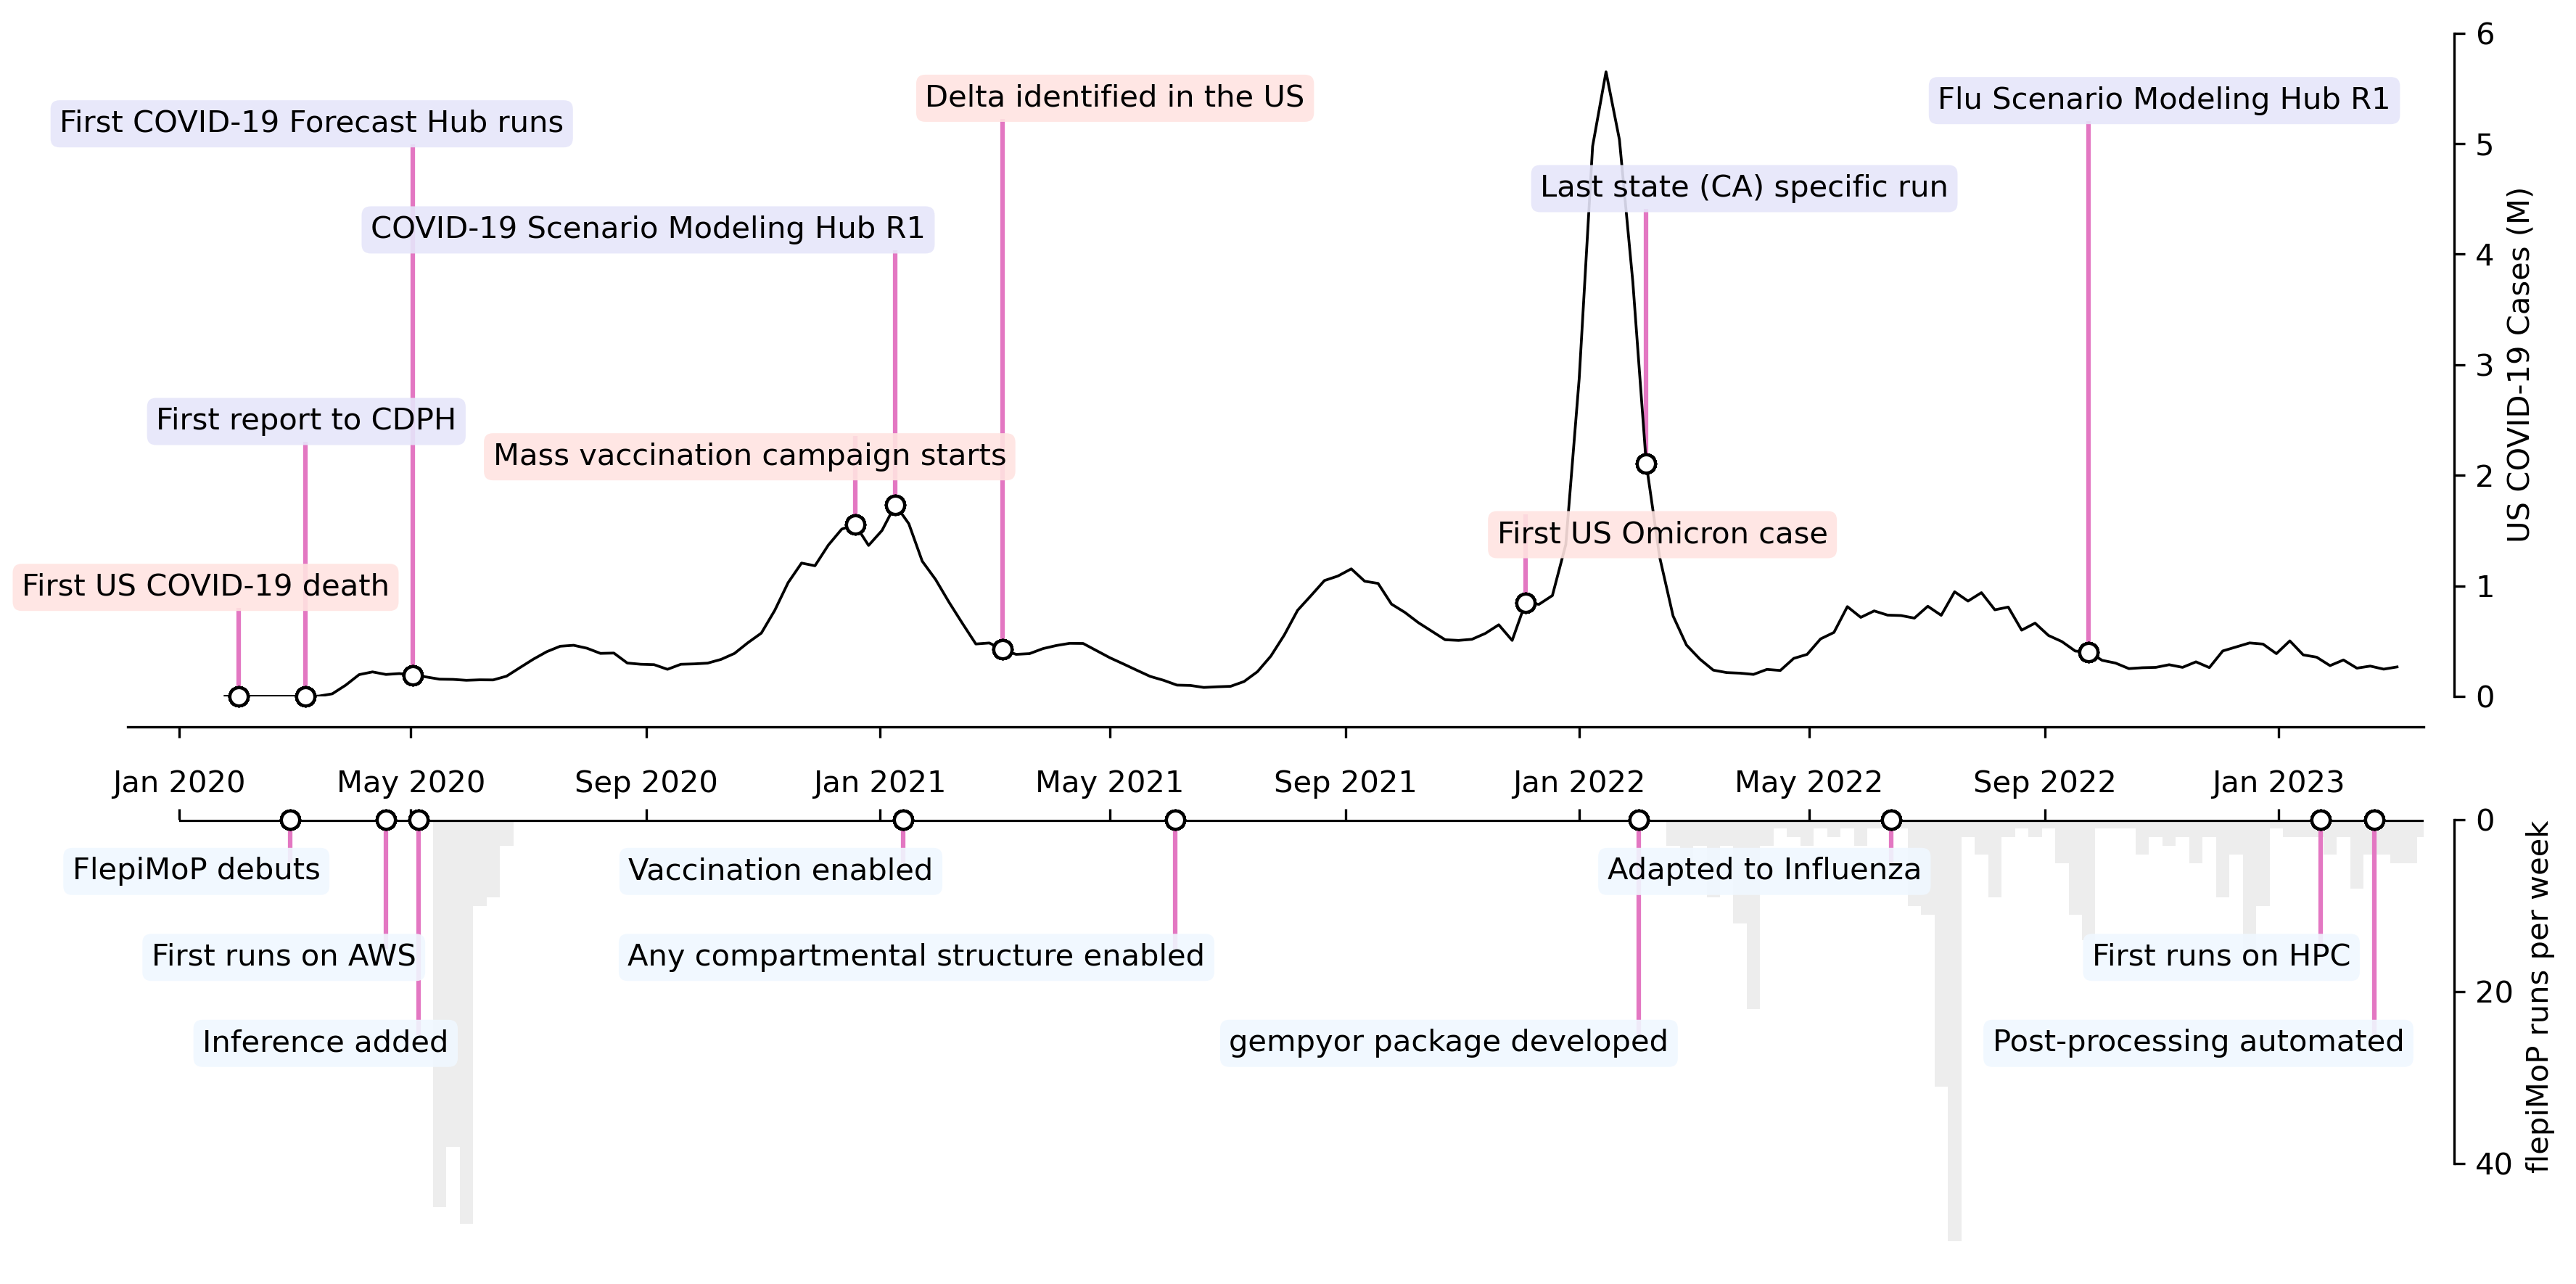

In [13]:
# Create figure and plot a stem plot with the date
fig, axes = plt.subplots(2,1, figsize=(12, 6), constrained_layout=True, sharex=True, dpi=300 , gridspec_kw={'height_ratios': [3, 2]})

xlims = [datetime.date(2019,12,5), epidata_df.index[-1]+datetime.timedelta(days=14)]


ax = axes[0]
# Choose some nice levels
base_level = 0
scale_level = 1
pos = vert_pos4
levels = get_levels(pos, base_level=base_level, scale_level=scale_level)

i=0
for  date, name, typ in zip(dates, names, types):
    # closest sat for weekly df:
    date_sat = date + datetime.timedelta(days=(5 - date.weekday()))
    if epidata_df.index[0] < date < epidata_df.index[-1]:
        base_level=(epidata_df/scale_df)[date_sat]
    else:
        base_level=0
    if typ != "tech":
        if i < 4:
            x_text_align = 50
        elif i < 5:
            x_text_align = 10
        else:
            x_text_align = 100
        plot_one_stem(ax=ax, date=date_sat, name=name, typ=typ, base_level=base_level, level=levels[i], x_text_align=x_text_align)
        i+=1


ax.plot(epidata_df/scale_df, c = 'k', lw='.9')

ax.set_ylim([0, 6])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position('right')

sns.despine(offset=10, right=False, trim = False, ax=ax)
for spine in [ "top", "left"]:
    ax.spines[spine].set_visible(False)

ax.set_xlim(xlims)
ax.set_ylabel("US COVID-19 Cases (M)")
#ax.get_xaxis().set_visible(False)

plot_one_stem(ax=ax, date=datetime.date(2023,3,1), 
              name="Technical changes", onlyannotate=True, typ="tech",x_text_align=0, base_level=0, level=8)
plot_one_stem(ax=ax, date=datetime.date(2023,3,1),
                name="Pandemic changes", onlyannotate=True, typ="epi",x_text_align=0, base_level=0, level=8+1.1*1)
plot_one_stem(ax=ax, date=datetime.date(2023,3,1),
                name="Mission changes", onlyannotate=True, typ="mission",x_text_align=0, base_level=0, level=8+1.1*2)




ax = axes[1]
# plot the runs
ax.bar(run_counts_w.index, run_counts_w, width=7, color='lightgray', alpha=.4)

# Choose some nice levels
base_level = 0
scale_level = 5
pos = vert_pos3
levels = get_levels(pos, base_level=base_level, scale_level=scale_level)


ax.hlines(base_level, datetime.date(2020,1,1), datetime.date(2023,4,15), color="k", linestyles="-", lw=1.5)

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > base_level).astype(int)]
i = 0
for date, level, name, typ, va in zip(dates, levels, names, types, vert):
    if typ == "tech":
        plot_one_stem(ax=ax, date=date, name=name, base_level=base_level, level=levels[i], typ=typ, inverted_axis=True)
        i += 1
ax.set_yticks([0,20,40],["0","20","40"])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position('right')


sns.despine(offset=10, right=False, trim = True, ax=ax)
ax.set_ylabel("flepiMoP runs per week", loc="top")#, rotation=270)

for spine in [ "top", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
#ax.get_yaxis().set_visible(False)
#ax.get_xaxis().set_visible(False)

#ax.set_ylim([0,40])
ax.invert_yaxis()

#ax.margins(y=0.1)

#ax.xaxis.set_major_locator(mpl.dates.MonthLocator((1,4, 7, 10)))
#ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%m-%Y'))
## format xaxis with 4 month intervals
# ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="right")
ax.xaxis.tick_top()




#plot closer together
plt.subplots_adjust(hspace=0)   
#axes.flat[1].xaxis.tick_top()

#fig.autofmt_xdate()
fig.tight_layout()
plt.show()

```# Create figure and plot a stem plot with the date
fig, axes = plt.subplots(2,1, figsize=(12, 6), constrained_layout=True, sharex=True, dpi=300)  # , gridspec_kw={'height_ratios': [1, 3]}

xlims = [datetime.date(2019,12,5), epidata_df.index[-1]]

ax = axes[0]
# plot the runs
ax.bar(run_counts_w.index, run_counts_w, width=7, color='lightgray', alpha=.4)

# Choose some nice levels
base_level = 0
scale_level = 10
pos=vert_pos2
levels = get_levels(pos, base_level=base_level, scale_level=scale_level)

ax.hlines(base_level, datetime.date(2020,1,1), datetime.date(2023,4,15), color="k", linestyles="-", lw=1.5)

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > base_level).astype(int)]
for d, l, r, t, va in zip(dates, levels, names, types, vert):
    plot_one_stem(ax=ax, date=d, name=r, base_level=base_level, level=l, typ=t, inverted_axis=False)

ax.set_yticks([0,20,40],["0","20","40"])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position('right')


sns.despine(offset=10, right=False, trim = True, ax=ax)
ax.set_ylabel("flepiMoP runs per week", loc="top")

for spine in [ "top", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

#ax.set_ylim([0,40])
#ax.invert_yaxis()

#ax.margins(y=0.1)


ax = axes[1]
# Choose some nice levels
base_level = 0
scale_level = 2
pos = vert_pos3
levels =get_levels(pos, base_level=base_level, scale_level=scale_level)

for i, (date, name, typ) in enumerate(zip(dates, names, types)):
    # closest sat for weekly df:
    date_sat = date + datetime.timedelta(days=(5 - date.weekday()))
    if epidata_df.index[0] < date < epidata_df.index[-1]:
        base_level=(epidata_df/scale_df)[date_sat]
    else:
        base_level=0
    if typ == "epi":
        plot_one_stem(ax=ax, date=date_sat, name=name, typ=typ, base_level=base_level, level=levels[i])


ax.plot(epidata_df/scale_df, c = 'k', lw='.9')

ax.set_xlim(xlims)
ax.set_ylim([0, 7])

for spine in ["right", "top",]:
    ax.spines[spine].set_visible(False)

sns.despine(offset = {"left" : 10, "bottom" : 10}, trim = True, ax=ax)

ax.xaxis.set_major_locator(mpl.dates.MonthLocator((1,4, 7, 10)))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
#ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%m--%Y'))
## format xaxis with 4 month intervals
# ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
# plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_ylabel("US COVID-19 Cases \n (100k)")

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [35]:
pop = pd.read_csv("../../COVID19_USA/data/geodata_2019_statelevel.csv", converters={"geoid": lambda x: str(x)[:2]})
mob = pd.read_csv("../../COVID19_USA/data/mobility_2011-2015_statelevel.csv", converters={"ori": lambda x: str(x)[:2], "dest": lambda x: str(x)[:2]})

<AxesSubplot:>

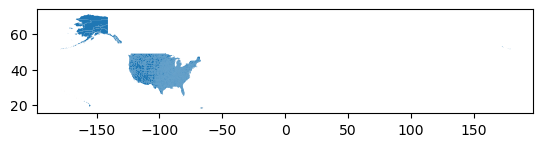

In [36]:
import geopandas as gpd
fp = "../../COVID19_USA/data/shp/counties_2010_AK-AL-AR-AZ-CA-CO-CT-DC-DE-FL-GA-HI-IA-ID-IL-IN-KS-KY-LA-MA-MD-ME-MI-MN-MO-MS-MT-NC-ND-NE-NH-NJ-NM-NV-NY-OH-OK-OR-PA-PR-RI-SC-SD-TN-TX-UT-VA-VT-WA-WI-WV-WY.shp"
us_states = gpd.read_file(fp)
us_states.plot()

<AxesSubplot:>

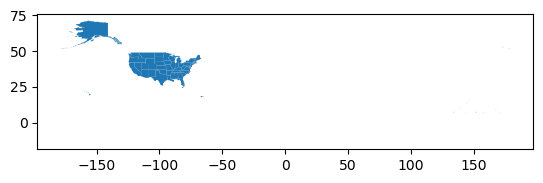

In [37]:
fp = "s_22mr22/s_22mr22.shp" # https://www.weather.gov/gis/USStates
us_states = gpd.read_file(fp)
us_states.plot()

In [38]:
import networkx as nx
# create a networkx graph from the mobility data
G = nx.from_pandas_edgelist(mob, source='ori', target='dest', edge_attr=True, create_using=nx.DiGraph())
G['01']['02']

{'amount': 198}

In [39]:
#us_states = pd.merge(left=us_states, right=pop, left_on="STATEFP", right_on="geoid", how="left")
us_states = pd.merge(left=us_states, right=pop, left_on="FIPS", right_on="geoid", how="inner")
us_states.set_index("geoid", inplace=True)

In [40]:
us_states

STATE                  NAME FIPS        LON       LAT  \
geoid                                                         
02       AK                Alaska   02 -152.24098  64.24019   
01       AL               Alabama   01  -86.82676  32.79354   
05       AR              Arkansas   05  -92.43920  34.89977   
04       AZ               Arizona   04 -111.66457  34.29323   
06       CA            California   06 -119.60818  37.24537   
08       CO              Colorado   08 -105.54783  38.99855   
09       CT           Connecticut   09  -72.72623  41.62196   
11       DC  District of Columbia   11  -77.01464  38.90932   
10       DE              Delaware   10  -75.50592  38.99559   
12       FL               Florida   12  -82.50934  28.67402   
13       GA               Georgia   13  -83.44848  32.65155   
15       HI                Hawaii   15 -156.34743  20.24923   
19       IA                  Iowa   19  -93.50003  42.07463   
16       ID                 Idaho   16 -114.65933  44.38907   
17       IL              Illinois   17  -89.19838  40.06501   
18       IN               Indiana   18  -86.27548  39.90801   
20       KS                Kansas   20  -98.38019  38.48471   
21       KY              Kentucky   21  -85.29046  37.52668   
22       LA             Louisiana   22  -92.02905  31.08910   
25       MA         Massachusetts   25  -71.81423  42.25788   
23       ME                 Maine   23  -69.22999  45.38046   
26       MI              Michigan   26  -85.43675  44.34717   
27       MN             Minnesota   27  -94.31357  46.31189   
28       MS           Mississippi   28  -89.66553  32.75201   
30       MT               Montana   30 -109.64507  47.03350   
37       NC        North Carolina   37  -79.37865  35.54369   
38       ND          North Dakota   38 -100.46935  47.44626   
31       NE              Nebraska   31  -99.81058  41.52709   
33       NH         New Hampshire   33  -71.57754  43.68556   
34       NJ            New Jersey   34  -74.66876  40.20049   
35       NM            New Mexico   35 -106.10837  34.42137   
32       NV                Nevada   32 -116.65539  39.35648   
36       NY              New York   36  -75.51491  42.94796   
39       OH                  Ohio   39  -82.79002  40.29120   
40       OK              Oklahoma   40  -97.50819  35.58345   
41       OR                Oregon   41 -120.55232  43.93589   
42       PA          Pennsylvania   42  -77.79930  40.87368   
44       RI          Rhode Island   44  -71.55579  41.67544   
46       SD          South Dakota   46 -100.23048  44.43614   
47       TN             Tennessee   47  -86.34332  35.84299   
48       TX                 Texas   48  -99.35939  31.49422   
49       UT                  Utah   49 -111.67822  39.32379   
51       VA              Virginia   51  -78.82957  37.51637   
50       VT               Vermont   50  -72.66273  44.07511   
53       WA            Washington   53 -120.43997  47.38076   
55       WI             Wisconsin   55  -90.01144  44.63725   
54       WV         West Virginia   54  -80.61372  38.64259   
56       WY               Wyoming   56 -107.55144  42.99963   
29       MO              Missouri   29  -92.38554  38.32080   
45       SC        South Carolina   45  -80.89899  33.93574   
24       MD              Maryland   24  -76.78588  39.04533   

                                                geometry USPS  pop2019est  
geoid                                                                      
02     MULTIPOLYGON (((-179.10754 51.30120, -179.1054...   AK      737068  
01     MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...   AL     4876250  
05     POLYGON ((-91.62986 36.49921, -91.62849 36.499...   AR     2999370  
04     POLYGON ((-110.49090 37.00361, -110.48750 37.0...   AZ     7050299  
06     MULTIPOLYGON (((-118.42620 32.79973, -118.4263...   CA    39283497  
08     POLYGON ((-106.87560 41.00301, -106.85850 41.0...   CO     5610349  
09     MULTIPOLYGON (((-73.62247 40.98430, -73.62209 ...  

In [41]:
us_states.loc["02","pop2019est"]

737068

/Users/chadi/opt/miniconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/chadi/opt/miniconda3/lib/python3.8/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-2400000.0, 1000000.0)

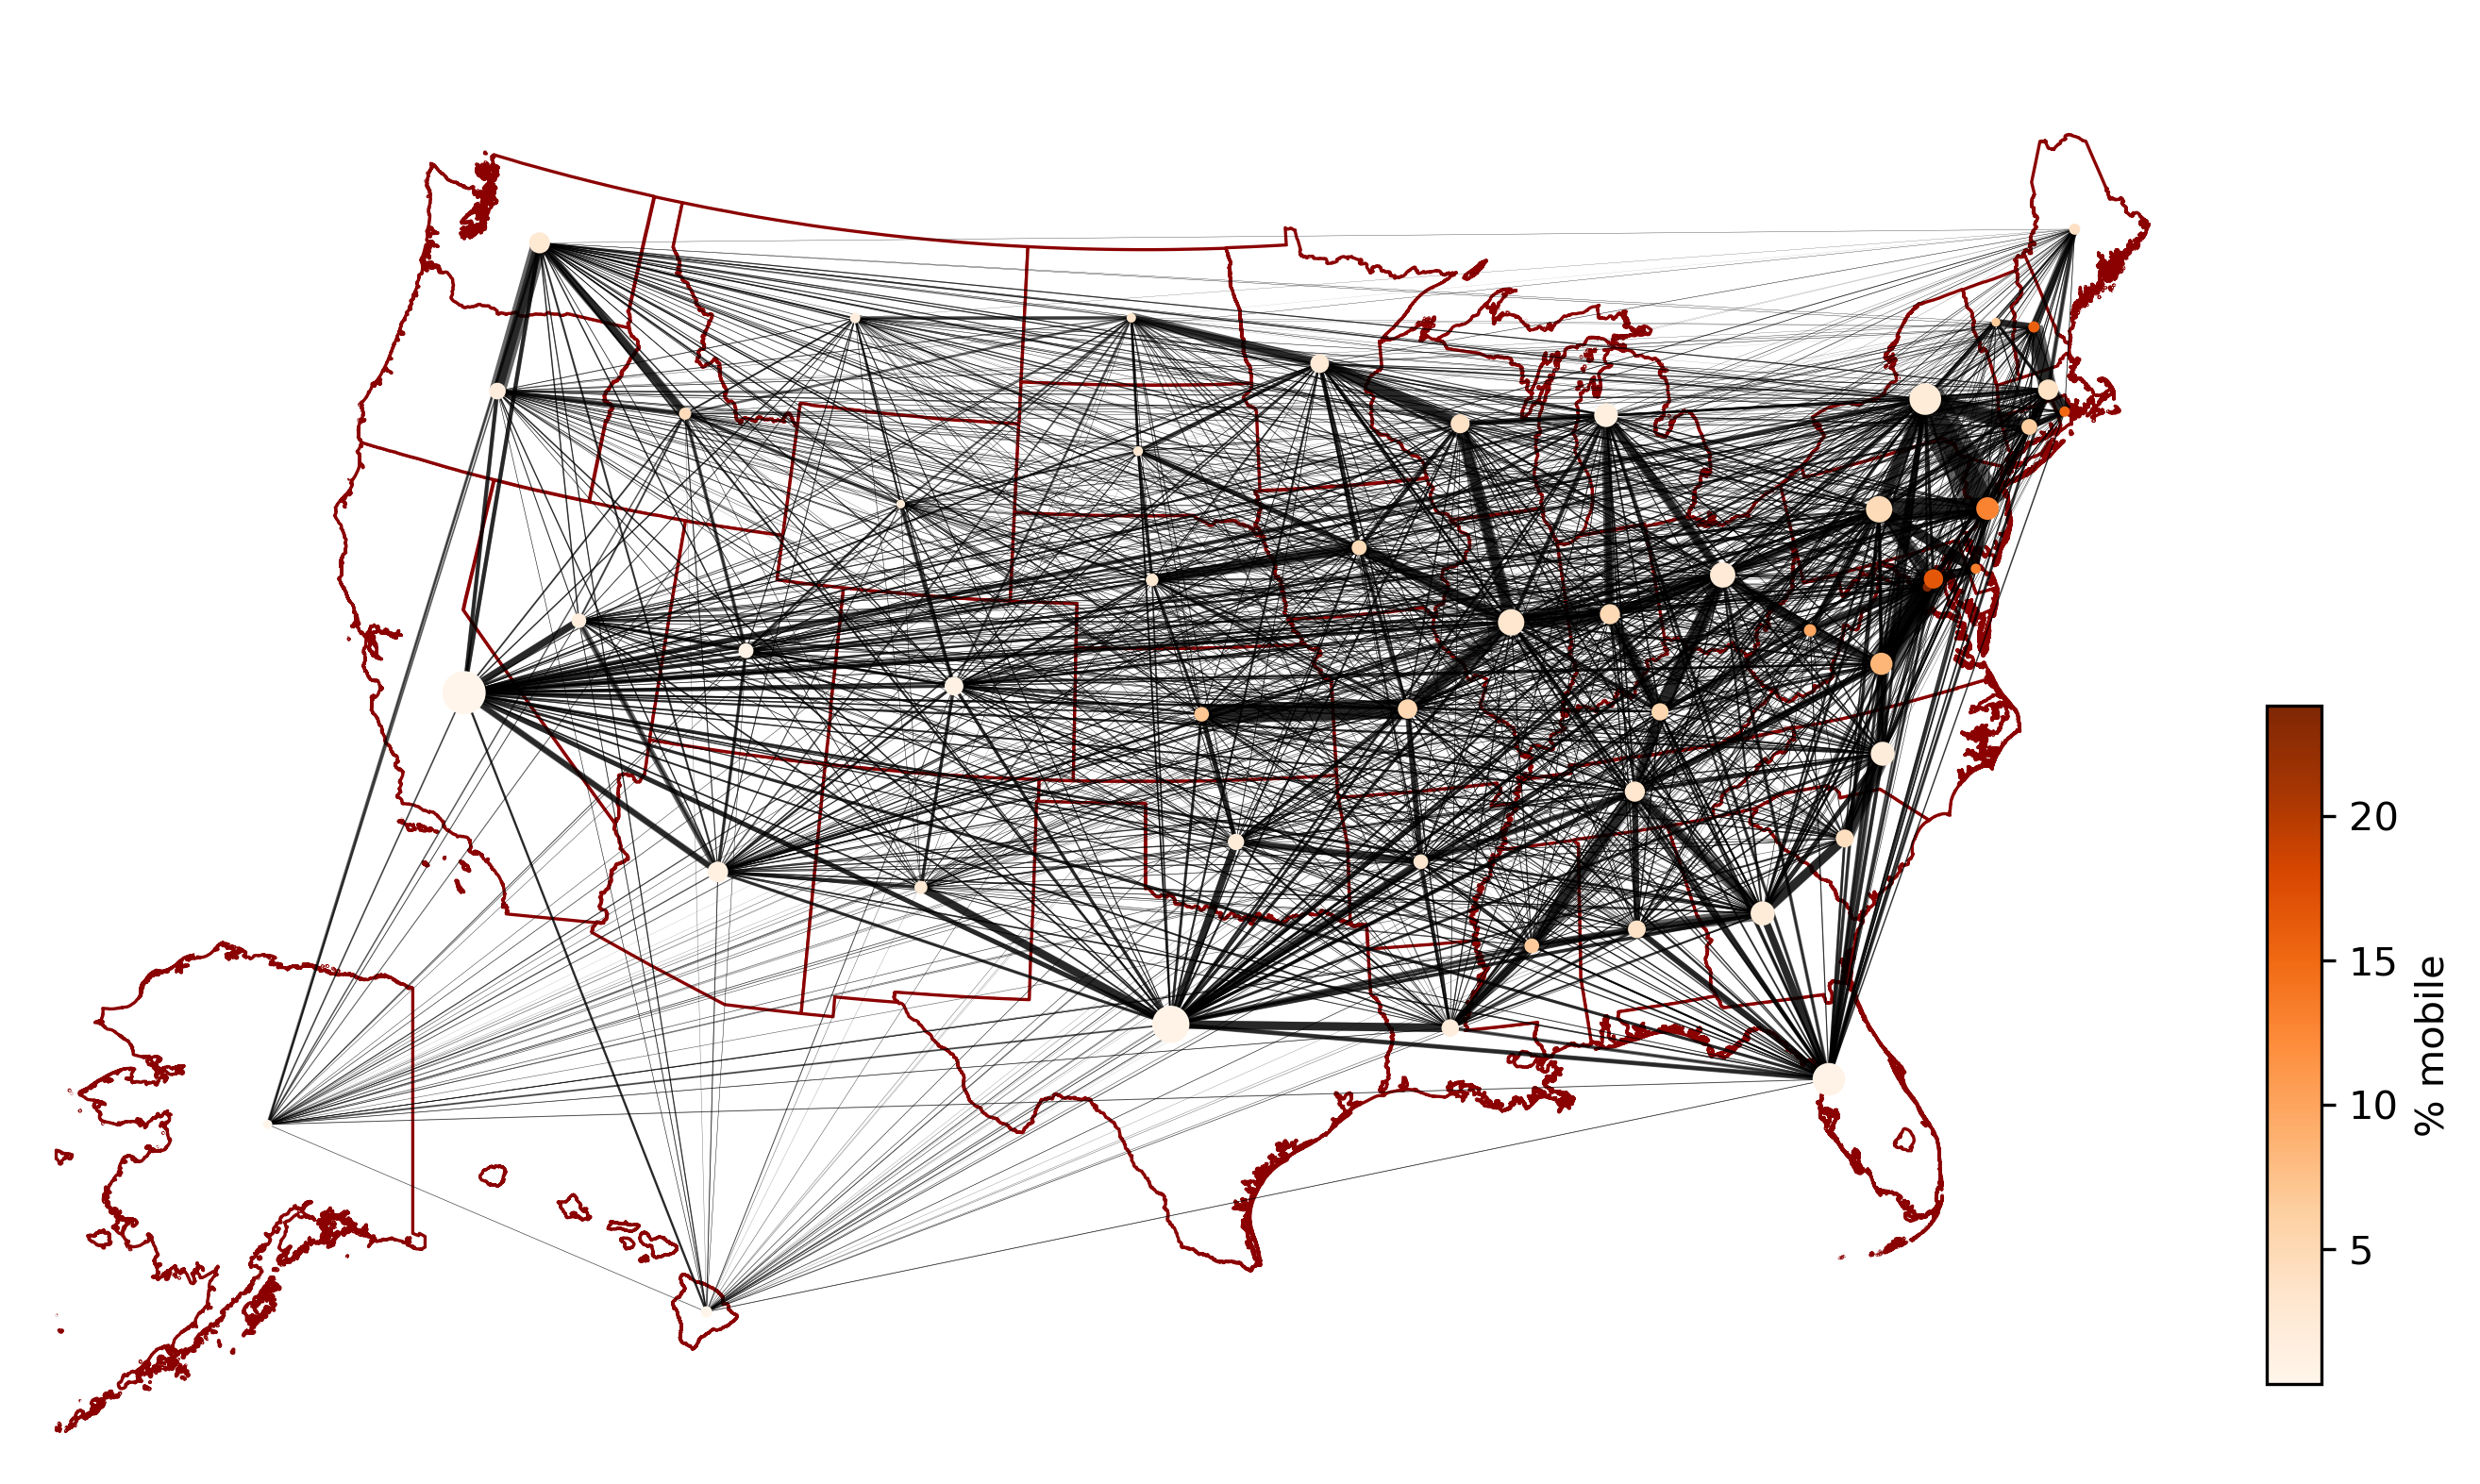

In [42]:
from shapely.geometry import Polygon
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
ax.patch.set_alpha(0.0)
#us_states.plot(column='pop2019est', ax=ax, legend=False, cmap='OrRd')
#ax.scatter(centroids[:, 0], centroids[:, 1], c='k', s=1)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = us_states.to_crs({'init':'epsg:2163'})

# create map of all states except AK and HI in the main map axis
#visframe[~visframe.state.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')

for row in visframe.itertuples():
    if row.STATE not in ['AK','HI']:
        vf = visframe[visframe.STATE==row.STATE]
        #c = us_states[us_states.STATE==row.STATE][0:1].value_determined_color.item()
        c='w'
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor="darkred")


# add Alaska
akax = fig.add_axes([0.1, 0.23, 0.2, 0.19], zorder=-1)   
akax.axis('off')
# polygon to clip western islands
akpolygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = us_states[us_states.STATE=='AK']
alaska_gdf.clip(akpolygon).plot(color='w', linewidth=0.8,ax=akax, edgecolor="darkred", zorder=-1)


# add Hawaii
hiax = fig.add_axes([.28, 0.25, 0.1, 0.1], zorder=-1)   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = us_states[us_states.STATE=='HI']
hawaii_gdf.clip(hipolygon).plot(column='pop2019est', color='w', linewidth=0.8,ax=hiax, edgecolor='darkred', zorder=-1)

pos={}
for n in G.nodes:
    pos[n] = np.array((visframe[visframe.FIPS==n].centroid.x, visframe[visframe.FIPS==n].centroid.y)).flatten()

#centroids = np.column_stack((visframe.centroid.x, visframe.centroid.y))
#pos = dict(zip(G.nodes, centroids))
pos['02'] = np.array((-2.2e6, -1.75e6))
pos['15'] = np.array((-1.1e6, -2.22e6))


node_sizes = np.array([us_states.loc[n,"pop2019est"] for n in G.nodes])/us_states["pop2019est"].max()*100
nodes_colors = np.array([mob[mob["ori"]==n]["amount"].sum()/us_states.loc[n,"pop2019est"] for n in G.nodes])*100
cmap = plt.cm.Oranges
vmin = min(nodes_colors)
vmax = max(nodes_colors)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=nodes_colors, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax);


weight = np.sqrt(np.array([G.get_edge_data(u, v)['amount'] for u, v in G.edges()]))
weight = weight/weight.max()*10
edges = nx.draw_networkx_edges(G,
                        pos,
                        ax=ax, 
                        node_size=node_sizes,
                        arrows=False,
                        #arrowsize=10,
                        width=weight, 
                        edge_color="k", 
                        alpha=.6);
#nx.draw_networkx_labels(G, pos, font_size=14, bbox={"ec": "k", "fc": "white", "alpha": 0.7}, ax=ax);

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width = "2.5%", height = "50%", loc = 'lower left',
                   bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, label="% mobile", cax=axins, fraction=0.02, pad=0.04, shrink=0.5)

ax.set_axis_off()
ax.set_xlim([-2.8e6, 2.7e6])
ax.set_ylim([-2.4e6, 1e6])

In [43]:
mob[mob["amount"] == mob["amount"].max()]

ori dest  amount
1405  34   36  833742

In [44]:
ax.viewLim

Bbox([[-2800000.0, -2400000.0], [2700000.0, 1000000.0]])